In [1]:
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import random
import matplotlib.pyplot as plt
import datetime
from typing import Union, List, Tuple
import os
import time
from keras.models import Model
from keras.layers import (BatchNormalization, Flatten, Input, Reshape, Dense, MaxPool2D,
                          Conv1D, Concatenate)
import tensorflow_probability as tfp

In [2]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, 
                data_directory_path: str = "./",
                labels_directory_path: str = "./",
                is_directory_recursive: bool = False,
                file_type: str = "*csv",
                data_format: str = "2D",
                batch_size: int = 32,
                file_count = None,
                labels_list: Union[List,str] = "cotAlpha",
                to_standardize: bool = False,
                input_shape: Tuple = (13,21),
                include_y_local:bool = False,
                use_inverse: bool = False,
                **kwargs,
                ):
        """
        Data Generator to streamline data input to the network direct from the directory.
        Args:
        data_directory_path:
        labels_directory_path: 
        is_directory_recursive: 
        file_type: Default: "*.csv"
                   Adapt the data loader according to file type. For now, it only supports .csv file format.
        data_format: Default: 2D
                     Used to refer to the relevant "recon" files, 2D for 2D pixel array, 3D for time series input,
        batch_size: Default: 32
                    The no. of data points to be included in a single batch.
        file_count: Default: None
                    To limit the no. of .csv files to be used for training.
                    If set to None, all files will be considered as legitimate inputs.
        labels_list: Default: "cotAlpha"
                     Input column name or list of column names to be used as label input to the neural network.
        to_standardize: If set to True, it ensures that batches are normalized prior to being used as inputs
                        for training.
                        Default: False
        input_shape: Default: (13,21) for image input to a 2D feedforward neural network.
                    To reshape the input array per the requirements of the network training.
        """
        self.recon_files = glob.glob(data_directory_path + "recon" + data_format + "*" + file_type, 
                                    recursive=is_directory_recursive)
        
        self.recon_files.sort()
        
        self.label_files = glob.glob(labels_directory_path + "labels" + "*" + file_type, 
                                     recursive=is_directory_recursive)
        self.label_files.sort()
        print(len(self.recon_files), len(self.label_files))
        if file_count != None:
            self.recon_files = self.recon_files[:file_count]
            self.label_files = self.label_files[:file_count]
            
        self.batch_size = batch_size
        self.labels_list = labels_list
        self.input_shape = input_shape
        self.to_standardize = to_standardize
        self.include_y_local = include_y_local
        self.use_inverse = use_inverse
        self.on_epoch_end()
        
    
    def standardize(self, x):
        """Applies the normalization configuration in-place to a batch of
        inputs.
        `x` is changed in-place since the function is mainly used internally
        to standardize images and feed them to your network.
        Args:
            x: Batch of inputs to be normalized.
        Returns:
            The inputs, normalized. 
        """
        x -= np.mean(x, keepdims=True)   
        x /= np.std(x, keepdims=True) + 1e-10
        return x
        
    
    def inverse(self, angle):
        return np.arctan(1.0/np.abs(angle))
            
    
    def on_epoch_end(self):
        """
        Inherited from the parent class.
        Used to reset indices but not of significance in this datagenerator.
        """
        pass
            
        
    def __getitem__(self, index):
        """
        Used to fetch a batch of inputs (X,y) for the network's training.
        """
        
        file_index = random.randrange(0,len(self.recon_files))
        recon_df = pd.read_csv(self.recon_files[file_index])
        labels_df = pd.read_csv(self.label_files[file_index])
        
        chosen_idxs = random.sample([i for i in range(0,len(recon_df))], self.batch_size)
        
        X = recon_df.iloc[chosen_idxs].values
        y = labels_df.iloc[chosen_idxs]
        # extract angle from cotangent of alpha and/or beta
        if self.use_inverse:
            if "cotAlpha" in self.labels_list:
                y["cotAlpha"].apply(func = self.inverse)
            elif "cotBeta" in self.labels_list:
                y["cotBeta"].apply(func = self.inverse)
        y = y[self.labels_list].values

        if len(self.input_shape) == 1:
            X = X.reshape(self.batch_size,self.input_shape[0])
        if len(self.input_shape) == 2:
            X = X.reshape(self.batch_size,self.input_shape[0],self.input_shape[1])
        elif len(self.input_shape) == 3:
            X = X.reshape(self.batch_size,self.input_shape[0],self.input_shape[1],
                          self.input_shape[2])
        elif len(self.input_shape) == 4:
            X = X.reshape(self.batch_size, self.input_shape[0], self.input_shape[1], 
                          self.input_shape[2], self.input_shape[3])
                  
        if self.to_standardize:
            X = self.standardize(X)
        if self.include_y_local:
            y_local = labels_df.iloc[chosen_idxs]["y-local"].values
            return [X, y_local], y
        else:
            return X, y/3.14159265359
    
    def __len__(self):
        count = 0
        for f in self.label_files:
            x = pd.read_csv(f)
            count += x.shape[0]
        return count // self.batch_size

In [3]:
def custom_loss(y, p):
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = 0.001 + tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)**2/(2*(sigma)**2))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)

def custom_loss_beta_distribution(y, p):
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    alpha = tf.gather(params=p, indices=[0], axis=1)
    beta = tf.gather(params=p, indices=[1], axis=1)
    dist = tfp.distributions.Beta(concentration1 = alpha,
                                  concentration0 = beta)
    likelihood = dist.prob(y)                            
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)    

In [4]:
class RegModelAlpha1D:

    def build_image_branch(self,inputs):
        x = tf.keras.layers.Dense(256, 
                               kernel_initializer = "glorot_normal", 
                               activation='sigmoid', 
                               use_bias = True,
                               name = "hidden_i")(inputs)
        x = tf.keras.layers.Dense(2, 
                               activation= "softplus", 
                               name = "final_output")(x)

        return x
 
    def assemble_model(self):
        inputs = tf.keras.layers.Input ( shape = (21,) )
        outputs = self.build_image_branch(inputs)
        model = tf.keras.models.Model(inputs =[inputs], 
                      outputs=outputs, 
                      name = "angle_alpha_1D_x_profile_model")
        print( model.summary() )
        return model

In [5]:
start_date = datetime.datetime.now ( )
epochs = 10
batch_size = 2048
val_batch_size = 2048
train_file_size = None
val_file_size = 25
training_generator = CustomDataGenerator(
                                            data_directory_path = "../data/1D/recon/",
                                            labels_directory_path = "../data/1D/labels/",
                                            is_directory_recursive = False,
                                            file_type = "*csv",
                                            data_format = "1DX",
                                            batch_size = batch_size,
                                            file_count = train_file_size,
                                            to_standardize= True,
                                            include_y_local= False,
                                            labels_list = "cotAlpha",
                                            use_inverse= True,
                                            input_shape = (21,)
                                        )

validation_generator = CustomDataGenerator(
                                            data_directory_path = "../data/1D/recon/",
                                            labels_directory_path = "../data/1D/labels/",
                                            is_directory_recursive = False,
                                            file_type = "*csv",
                                            data_format = "1DX",
                                            batch_size = val_batch_size,
                                            file_count = val_file_size,
                                            to_standardize= True,
                                            include_y_local= False,
                                            labels_list = "cotAlpha",
                                            use_inverse = True,
                                            input_shape = (21,),       
                                           )

# es = keras.callbacks.EarlyStopping(monitor="val_loss",
#                                    patience = 10,
#                                   restore_best_weights = True)
# def lr_schedule(epoch, lr):
#     """
#     Reduces the learning rate by 0.9 if the epoch % 10 == 0 that is for every 10th epoch.
#     Args:
#         epoch: Training epoch number
#         lr: learning rate for the optimizer.
#     Returns: Updated learning rate
#     """
#     if (epoch % 10) == 0 and epoch != 0:
#         lr *= 0.9
#     return lr

# # lr_decay = keras.callbacks.LearningRateScheduler (lr_schedule , verbose=10)
model = RegModelAlpha1D().assemble_model()

model.compile(
            optimizer = tf.keras.optimizers.legacy.Adam(lr = 0.0075),
            loss = custom_loss_beta_distribution
            )

history = model.fit(
                    x=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    verbose = True 
                   )

end_date = datetime.datetime.now ( )
print ( "Total Training Time = {}".format (end_date - start_date ) )

80 80
80 80
Metal device set to: Apple M1
Model: "angle_alpha_1D_x_profile_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 hidden_i (Dense)            (None, 256)               5632      
                                                                 
 final_output (Dense)        (None, 2)                 514       
                                                                 
Total params: 6,146
Trainable params: 6,146
Non-trainable params: 0
_________________________________________________________________
None


2023-02-06 16:36:21.382115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-06 16:36:21.382136: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/gpradhan/miniforge3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-02-06 16:36:23.586910: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2023-02-06 16:36:25.413836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


972/972 [==============================] - ETA: 0s - loss: -20.7156

2023-02-06 16:37:15.366535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


972/972 [==============================] - 65s 65ms/step - loss: -20.7156 - val_loss: -20.7232
Epoch 2/10
972/972 [==============================] - 64s 64ms/step - loss: -20.7233 - val_loss: -20.7232
Epoch 3/10
972/972 [==============================] - 64s 64ms/step - loss: -20.7233 - val_loss: -20.7232
Epoch 4/10
972/972 [==============================] - 64s 64ms/step - loss: -20.7233 - val_loss: -20.7232
Epoch 5/10
972/972 [==============================] - 65s 65ms/step - loss: -20.7233 - val_loss: -20.7232
Epoch 6/10
972/972 [==============================] - 63s 63ms/step - loss: -20.7233 - val_loss: -20.7232
Epoch 7/10
972/972 [==============================] - 63s 63ms/step - loss: -20.7233 - val_loss: -20.7232
Epoch 8/10
972/972 [==============================] - 63s 63ms/step - loss: -20.7233 - val_loss: -20.7232
Epoch 9/10
972/972 [==============================] - 63s 63ms/step - loss: -20.7233 - val_loss: -20.7232
Epoch 10/10
972/972 [==============================] - 63

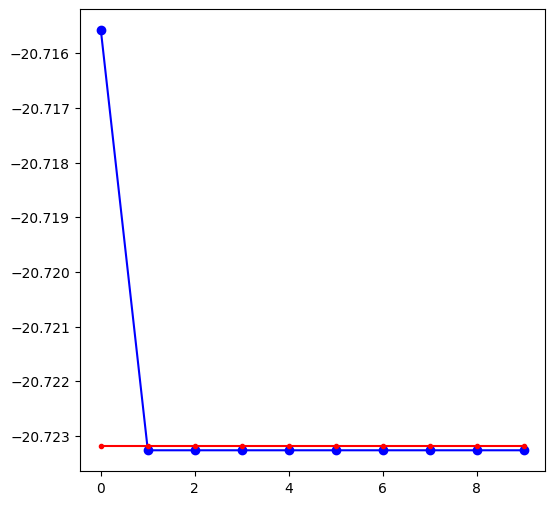

In [6]:
plt.figure(figsize = (6,6))
plt.plot(history.history["loss"], color = "blue",marker = "o")
plt.plot(history.history["val_loss"], color ="red", marker = ".")
plt.show()

### Test Phase:

In [7]:
test_recon = pd.read_csv("../data/1D/test/reconTest_1Dx.csv")
test_labels_df = pd.read_csv("../data/1D/test/labelsTest.csv")
test_labels = np.absolute(test_labels_df["cotAlpha"].values)
print(test_recon.shape, test_labels.shape)

(125498, 21) (125498,)


In [9]:
# test_inputs = test_recon.values.reshape(test_recon.shape[0],21,1)

def standardize(x):
    """Applies the normalization configuration in-place to a batch of
    inputs.
    `x` is changed in-place since the function is mainly used internally
    to standardize images and feed them to your network.
    Args:
        x: Batch of inputs to be normalized.
    Returns:
        The inputs, normalized. 
    """
    x -= np.mean(x, keepdims=True)   
    x /= np.std(x, keepdims=True) + 1e-10
    return x

test_inputs = standardize(test_recon.values)
cotAlpha_predictions = model.predict(test_inputs, batch_size = 1000)
alpha = cotAlpha_predictions[:,0]
beta = cotAlpha_predictions[:,1]
sum_term = alpha + beta
prod_term = alpha*beta
mu = alpha/(alpha+beta)
uncertainty = sum_term/(prod_term*(alpha+beta+1.0))
df = pd.DataFrame(mu, columns = ["predictions"])
df["uncertainty"] = uncertainty
# df = pd.DataFrame(cotAlpha_predictions, columns = ["predictions","uncertainty"])
# df["uncertainty"] = 0.001 + tf.math.softplus(df["uncertainty"])
df["truth"] = test_labels
df

126/126 [==============================] - 0s 2ms/step


,predictions,uncertainty,truth
0,NaN,NaN,1.145240
1,NaN,NaN,1.460190
2,NaN,NaN,0.686055
3,NaN,NaN,3.290910
4,NaN,NaN,3.549410
...,...,...,...
125493,NaN,NaN,0.398301
125494,NaN,NaN,1.186930
125495,NaN,NaN,1.050710
125496,NaN,NaN,1.215030


In [ ]:
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(df["truth"], bins = 100, color = "green", histtype = "step" )
plt.hist(df["predictions"], bins = 100, color = "red", histtype = "step" )
plt.xlabel(r'$_{cot\alpha}$')
plt.legend(["truth", "1d model"])
plt.xlim([-1,9])
# plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

In [ ]:
residuals = df["truth"] - df["predictions"]
print(np.mean(residuals), np.std(residuals))
plt.figure(figsize = (7,5), dpi = 80)
plt.hist(residuals, bins = 100, color = "red", histtype = "step")
plt.legend(["Residuals"])
# plt.xlim([-1,1])
# plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

In [ ]:
# pulls = residuals/ df["uncertainty"]
# print(np.mean(pulls), np.std(pulls))
# plt.figure(figsize = (7,5), dpi = 80)
# plt.hist(pulls, bins = 1000, color = "green", histtype = "step")
# plt.xlim([-10,10])
# plt.legend(["Pulls"])
# plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
# plt.show()

In [ ]:
from scipy.optimize import curve_fit
def gaus(x,a,mu,sig):
    """
    :param x: Input array for which a gaussian approximation is to be generated.
    :param a: Number of values in the input array, x.
    :param mu: mean of the distribution.
    :param sig: standard deviation for the distribution.
    :return: Array with gaussian representation = a*np.exp(-0.5*np.square((x-mu)/sig))
    """
    return a*np.exp(-0.5*np.square((x-mu)/sig))

def fit_gaus(hist, edges, mu=0., sig=1.):
    """
    Helper function to fit the gaussian approximation to a curve.
    :param hist: histogram data entries on y-axis
    :param edges: histogram data for the x-axis
    :param mu: mean of the distribution
    :param sig: standard deviation for the distribution
    :return: plot values for the guassian fitted data
    """

    hist = hist.astype ('float64')
    edges = edges.astype ('float64')
    xdata = (edges [1:] + edges [:-1]) / 2
    ydata = hist
    popt, pcov = curve_fit (gaus, xdata, ydata, p0=[np.max (hist), mu, sig])
    if not np.isfinite (pcov).all ():
        raise Exception ('Fit has failed to converge.')
    return popt

In [ ]:
# plt.figure(figsize=(7, 5), dpi=90)
# pulls = (df["truth"] - df["predictions"])/df["uncertainty"]
# print("Pulls Stats=", np.mean(pulls), np.std(pulls))
# hist, edges, _ = plt.hist(pulls,
#                       bins=1000,
#                       histtype='stepfilled',
#                       facecolor='green',
#                       alpha=0.2)
# mu_yy = np.mean(pulls)
# sig_yy = np.std(pulls)
# popt = fit_gaus(hist, edges, mu=mu_yy, sig=sig_yy)
# xdata = (edges[1:] + edges[:-1]) / 2
# plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='darkgreen', linestyle = "-.")
# # plt.xticks([i for i in range(-5,6,1)])
# # plt.xlim(-5,5)
# plt.legend(["Pulls", "Gaussian Approx"])
# # plt.yscale(value = "symlog")
# # plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
# plt.show()

In [ ]:
# plt.figure(figsize = (5,5), dpi = 80)
# plt.hist(df["uncertainty"],bins = 500, color = "blue", histtype = "step")
# plt.legend(["Uncertainty"])
# # plt.xlim([0,0.25])
# # plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
# plt.show()

In [ ]:
import seaborn as sns
# plt.figure(figsize = (7,5), dpi = 80)
# x = sns.regplot(x=df['truth'], y=df['uncertainty'], x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.', 
#                 color = "orange")
# plt.xlabel(r'True $_{cot\alpha}$')
# plt.ylabel(r'uncertainty $\sigma$')
# # plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
# plt.show()

In [ ]:
plt.figure(figsize = (7,5), dpi = 80)
x = sns.regplot(x=df['truth'], y=df['truth'] - df['predictions'], x_bins=np.linspace(-8,8,50), fit_reg=None, 
                marker='+', color = "orange" )
plt.xlabel(r'True $_{cot\alpha}$')
plt.ylabel(r'Res $_{cot\alpha}$')
# plt.grid(which='major', linestyle='-', linewidth='0.5', alpha=0.5,color='black')
plt.show()

In [ ]:
# model.save("./models/keras_cnn_1d_cotAlpha_model.h5")